In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
#pd.set_option('display.max_colwidth', -1)
import numpy as np

In [94]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score , KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler , PolynomialFeatures

#### Lectura del dataset

In [5]:
df = pd.read_csv('palermo_deptos_final.csv')
df.head(2)

,Unnamed: 0,id,superficie,cubierta,precio,piso,expensas,descripcion,ambientes,pileta,...,parrilla,balcon,cochera,geometry,dist_comisarias,dist_subte,dist_trenes,dist_metrobus,antiguedad,barrio
0,0,19,104.0,96.0,3365.384615,NaN,NaN,Excelente semipiso al contra frente en Bulnes ...,3,0,...,0,1,0,POINT (-58.4058744847 -34.580503566),719.300376,991.604946,794.459912,1500.489635,usado,Norte
1,1,209,68.0,48.0,3455.882353,NaN,NaN,"Excelente 2 Ambientes orientacion Este, Muy lu...",2,1,...,0,0,0,POINT (-58.4372870022 -34.56457657510001),980.716124,906.891789,260.100239,876.358223,estrenar,Las Cañitas


In [6]:
df = df.loc[:, ['barrio', 'antiguedad', 'superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
                'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes', 'dist_metrobus', 'precio']]

## Dataset 1  
Sin diferenciación de barrios y con dummies en antiguedad  

In [7]:
df1 = df.loc[:, ['antiguedad', 'superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
                'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes', 'dist_metrobus', 'precio']]

#### Agregar variables dummy - Discretización

In [8]:
antiguedad_dummy = pd.get_dummies((df1.antiguedad), drop_first=True, dtype='int')

In [9]:
df1 = pd.concat([df1, antiguedad_dummy], axis=1)

In [10]:
df1.drop(['antiguedad'], axis=1, inplace=True)

In [11]:
df1.head()

,superficie,ambientes,pileta,parrilla,seguridad,balcon,cochera,dist_comisarias,dist_subte,dist_trenes,dist_metrobus,precio,pozo,usado
0,104.0,3,0,0,0,1,0,719.300376,991.604946,794.459912,1500.489635,3365.384615,0,1
1,68.0,2,1,0,0,0,0,980.716124,906.891789,260.100239,876.358223,3455.882353,0,0
2,69.0,2,1,0,0,0,1,894.771967,791.276622,371.547893,766.818862,3447.753623,0,1
3,39.0,1,0,1,1,1,0,354.987173,115.947579,1737.834489,1285.978768,3776.923077,0,0
4,47.0,2,0,0,0,1,0,773.123345,357.007275,326.555566,190.245217,2872.340426,0,0


### Regresión Lineal

In [273]:
class ModeloDeRegresion():
    

    kf = KFold(n_splits=5, shuffle=True, random_state=12)

    
    def __init__(self , X_train , y_train , X_test , y_test , alpha_min , alpha_max):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.alpha_min = alpha_min
        self.alpha_max = alpha_max
        
        self.al_lasso = np.linspace(self.alpha_min, self.alpha_max , 30)
        self.al_ridge = np.linspace(self.alpha_min, self.alpha_max , 30)  
        
  
    
    def RegresionLineal(self):
        # Training
        lm_model = LinearRegression()
        lm_model.fit(X_train , y_train)
        y_pred = lm_model.predict(X_train)
        r2_train = metrics.r2_score(y_train,y_pred)
        mse_train = metrics.mean_squared_error(y_train , y_pred)
        
        # Testing
        y_pred_test = lm_model.predict(X_test)
        r2_test = metrics.r2_score(y_test,y_pred_test)
        mse_test = metrics.mean_squared_error(y_test , y_pred_test)
        print("------ Regresion Lineal ------\n")
        print('R2 Train: {} -- R2 Test: {}'  .format(r2_train , r2_test))
        print('mse Train: {} -- mse Test: {}'  .format(mse_train , mse_test))

        print("\n")
        return y_pred , y_pred_test
        
        
    
    def Lasso(self):
        lm_LassoCV = LassoCV(alphas=self.al_lasso, cv=self.kf, normalize=False)
        lm_LassoCV.fit(X_train , y_train)
        y_pred = lm_LassoCV.predict(X_train)
        
        # Metricas
        r2_train = metrics.r2_score(y_train,y_pred)
        mse_train = metrics.mean_squared_error(y_train , y_pred)
        
        # Testing
        a = lm_LassoCV.alpha_
        lasso_final = Lasso(alpha=a)
        lasso_final.fit(X_train , y_train)
        y_pred_test = lasso_final.predict(X_test)
        r2_test = metrics.r2_score(y_test,y_pred_test)
        mse_test = metrics.mean_squared_error(y_test , y_pred_test)
        error_abs = y_train - y_pred
        
        print("------ Modelo Lasso ------\n")
        print('Alpha Lasso:',lm_LassoCV.alpha_)
        print('R2 Train: {} -- R2 Test: {}'  .format(r2_train , r2_test))
        print('mse Train: {} -- mse Test: {}'  .format(mse_train , mse_test))
        print("\n")
        
        return y_pred , y_pred_test , lm_LassoCV.intercept_ , lm_LassoCV.coef_

    
    def Ridge(self):
        
        # Training 
        
        lm_RidgeCV = RidgeCV(alphas=self.al_ridge, cv=self.kf, normalize=False)
        lm_RidgeCV.fit(X_train , y_train)
        y_pred = lm_RidgeCV.predict(X_train)
        r2_train = metrics.r2_score(y_train,y_pred)
        mse_train = metrics.mean_squared_error(y_train , y_pred)
        
        
        # Testing
        
        y_pred_test = lm_RidgeCV.predict(X_test)
        r2_test = metrics.r2_score(y_test,y_pred_test)
        mse_test = metrics.mean_squared_error(y_test , y_pred_test)
        print("------ Modelo Ridge ------\n")
        print('Alpha Ridge:',lm_RidgeCV.alpha_)
        print('R2 Train: {} -- R2 Test: {}'  .format(r2_train , r2_test))
        print('mse Train: {} -- mse Test: {}'  .format(mse_train , mse_test))
        
        return y_pred , y_pred_test

def plots():  
    fig = plt.figure(figsize=(15,8))
    
    
    ax1 = fig.add_subplot(231)
    ax1.set_title("Regresion Lineal")
    ax1.scatter(y_train , y_pred_lm);

    ax2 = fig.add_subplot(232)
    ax2.set_title("Regresion Lasso")
    ax2.scatter(y_train , y_pred_lasso);

    ax3 = fig.add_subplot(233)
    ax3.set_title("Regresion Ridge")
    ax3.scatter(y_train , y_pred_ridge);
    
    ax1.set_xlabel("Actual")
    ax2.set_xlabel("Actual")
    ax3.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    
    ax4 = fig.add_subplot(234)
    ax4.scatter(y_pred_lm , y_train - y_pred_lm);
    
    ax5 = fig.add_subplot(235)
    ax5.scatter(y_pred_lasso , y_train - y_pred_lasso);
    
    ax6 = fig.add_subplot(236)
    ax6.scatter(y_pred_ridge , y_train - y_pred_ridge);
    
    ax4.set_xlabel("Predicted")
    ax5.set_xlabel("Predicted")
    ax6.set_xlabel("Predicted")
    ax4.set_ylabel("Residuos")

------ Regresion Lineal ------

R2 Train: 0.26675700573156547 -- R2 Test: 0.2854522736231365
mse Train: 702600.7103793102 -- mse Test: 747568.9132198114


------ Modelo Lasso ------

Alpha Lasso: 0.6993103448275861
R2 Train: 0.26670275581293534 -- R2 Test: 0.2855659335409121
mse Train: 702652.6931894638 -- mse Test: 747450.0007692198


------ Modelo Ridge ------

Alpha Ridge: 0.01
R2 Train: 0.26675700417424775 -- R2 Test: 0.28545053669342346
mse Train: 702600.7118715475 -- mse Test: 747570.7304177536


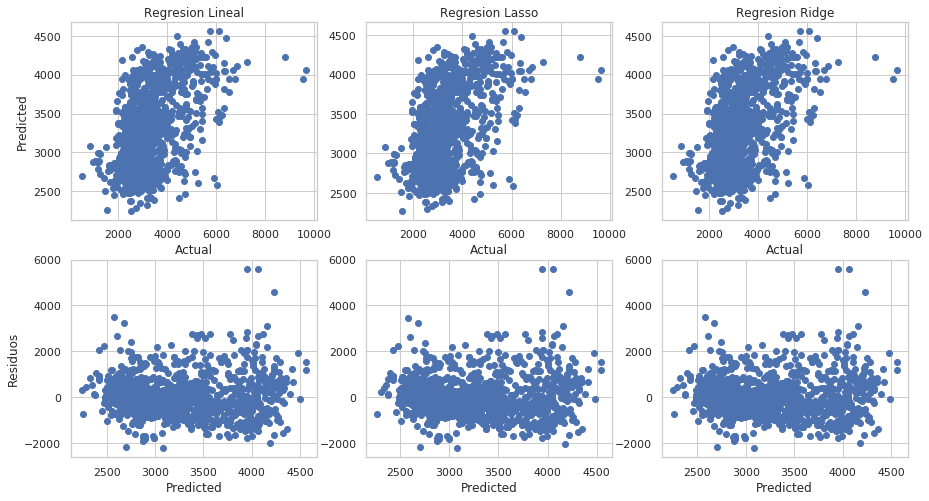

In [274]:
#Modelo 1 -- Variables sin Estandarizar.

np.set_printoptions(suppress=True)
X1 = df1[['superficie' , 'ambientes' , 'pileta' , 'parrilla' , 'seguridad' , 'balcon' , 'cochera' , 'dist_comisarias' , 'dist_subte' , 'dist_trenes' , 'dist_metrobus' , 'pozo' , 'usado']]
y1 = df1.precio
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=123)

ml1 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 0.01 , 20)


y_pred_lm , y_pred_test_lm = ml1.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml1.Lasso()
y_pred_ridge , y_pred_test_ridge = ml1.Ridge()

plots()

------ Regresion Lineal ------

R2 Train: 0.2557509058757147 -- R2 Test: 0.2779086661764618
mse Train: 0.06139531612056448 -- mse Test: 0.06478794336640611


------ Modelo Lasso ------

Alpha Lasso: 0.01
R2 Train: 0.2301840069261405 -- R2 Test: 0.24092377193530712
mse Train: 0.06350440547737263 -- mse Test: 0.068106325849714


------ Modelo Ridge ------

Alpha Ridge: 14.48551724137931
R2 Train: 0.2556849235000844 -- R2 Test: 0.2768174413931893
mse Train: 0.06140075920251403 -- mse Test: 0.06488585093868555


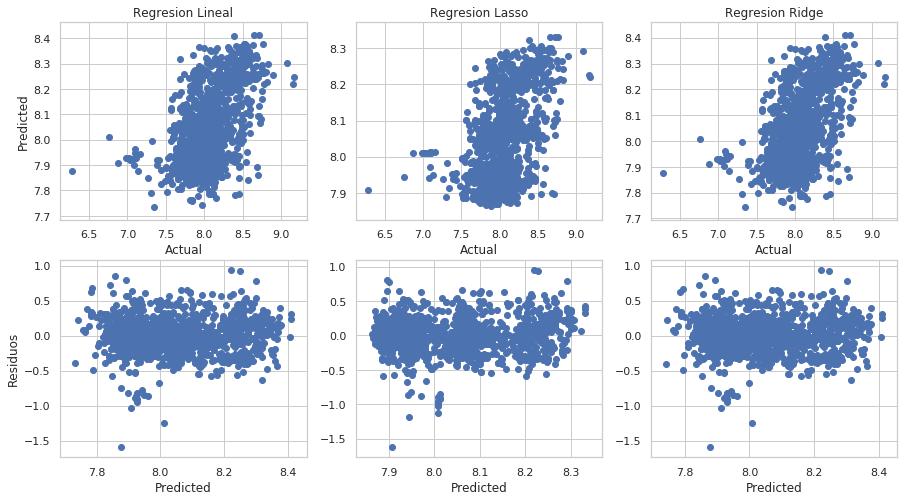

In [275]:
#Modelo 2 -- Variables Estandarizadas.

X2 = df1[['superficie' , 'ambientes' , 'pileta' , 'parrilla' , 'seguridad' , 'balcon' , 'cochera' , 'dist_comisarias' , 'dist_subte' , 'dist_trenes' , 'dist_metrobus' , 'pozo' , 'usado']]
y2 = df1.precio

se = StandardScaler()

X2 = se.fit_transform(X2)
y2 = np.log(y2)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=123)

ml2 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 0.01 , 20)


y_pred_lm , y_pred_test_lm = ml2.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml2.Lasso()
y_pred_ridge , y_pred_test_ridge = ml2.Ridge()



plots()

------ Regresion Lineal ------

R2 Train: 0.6885752498267143 -- R2 Test: -5.2623136338525225e+19
mse Train: 298410.2847375397 -- mse Test: 5.505499407615643e+25


------ Modelo Lasso ------

Alpha Lasso: 8.10344827586207
R2 Train: 0.4456554721480308 -- R2 Test: 0.41858558059605133
mse Train: 531178.4253080641 -- mse Test: 608283.1553436333


------ Modelo Ridge ------

Alpha Ridge: 20.0
R2 Train: 0.5650884618424747 -- R2 Test: 0.4095186260594036
mse Train: 416736.54988890246 -- mse Test: 617769.1184206472


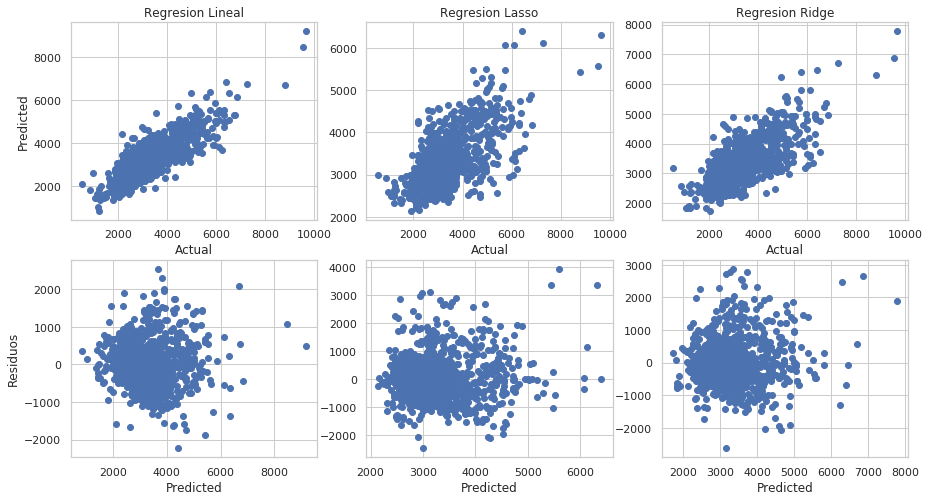

In [277]:
#Modelo 3 -- Modelo de Grado 3.

X3 = df1[['superficie' , 'ambientes' , 'pileta' , 'parrilla' , 'seguridad' , 'balcon' , 'cochera' , 'dist_comisarias' , 'dist_subte' , 'dist_trenes' , 'dist_metrobus' , 'pozo' , 'usado']]
y3 = df1.precio

# Agrego un polinomio de Grado 3 y transformo los datos
poly = PolynomialFeatures(degree=3)
se = StandardScaler()
X3 = poly.fit_transform(X3)
X3 = se.fit_transform(X3)


X_train, X_test, y_train, y_test = train_test_split(X3, y3, random_state=123)

ml3 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 5 , 20)


y_pred_lm , y_pred_test_lm = ml3.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml3.Lasso()
y_pred_ridge , y_pred_test_ridge = ml3.Ridge()



plots()

------ Regresion Lineal ------

R2 Train: 0.2523272233790519 -- R2 Test: 0.2674326478667489
mse Train: 0.06167774584851246 -- mse Test: 0.06572787942319444


------ Modelo Lasso ------

Alpha Lasso: 20.0
R2 Train: 0.0 -- R2 Test: -0.0049897137392587165
mse Train: 0.08249296721389332 -- mse Test: 0.09017033387284967


------ Modelo Ridge ------

Alpha Ridge: 19.48275862068966
R2 Train: 0.2522012540724309 -- R2 Test: 0.2671916733904781
mse Train: 0.06168813743039351 -- mse Test: 0.06574950029023727


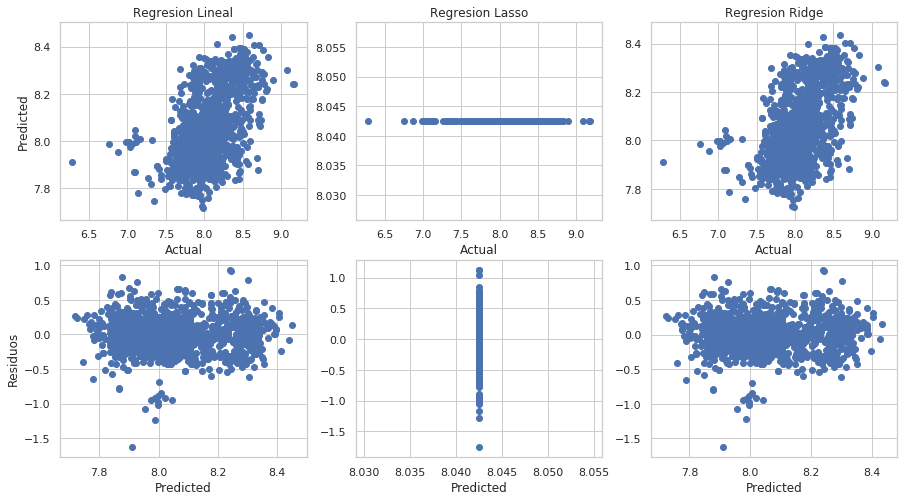

In [278]:
#Modelo 8 -- Modelo Logaritmico.

X8 = df1[['superficie' , 'ambientes' , 'pileta' , 'parrilla' , 'seguridad' , 'balcon' , 'cochera' , 'dist_comisarias' , 'dist_subte' , 'dist_trenes' , 'dist_metrobus' , 'pozo' , 'usado']]
y8 = df1.precio


se = StandardScaler()
X8 = X8.applymap(lambda x: np.log(x + 1))
X8 = se.fit_transform(X8)

y8 = np.log(y8)

X_train, X_test, y_train, y_test = train_test_split(X8, y8, random_state=123)

ml8 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 5 , 20)


y_pred_lm , y_pred_test_lm = ml8.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml8.Lasso()
y_pred_ridge , y_pred_test_ridge = ml3.Ridge()


plots()

## Dataset 2
Con diferenciación de barrios y con dummies en antiguedad

In [119]:
df2 = df.loc[:, ['barrio', 'antiguedad', 'superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
                'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes', 'dist_metrobus', 'precio']]

#### Agregar variables dummy - Discretización

In [120]:
barrio_dummy = pd.get_dummies(df2.barrio, drop_first=True, dtype='int')
antiguedad_dummy = pd.get_dummies((df2.antiguedad), drop_first=True, dtype='int')

In [121]:
df2 = pd.concat([df2, barrio_dummy], axis=1)
df2 = pd.concat([df2, antiguedad_dummy], axis=1)

In [122]:
df2.drop(['barrio', 'antiguedad'], axis=1, inplace=True)

In [123]:
df2.head()
df2.columns

,superficie,ambientes,pileta,parrilla,seguridad,balcon,cochera,dist_comisarias,dist_subte,dist_trenes,...,Freud,Hollywood,Las Cañitas,Norte,Nuevo,Pacifico,Soho,Zoo,pozo,usado
0,104.0,3,0,0,0,1,0,719.300376,991.604946,794.459912,...,0,0,0,1,0,0,0,0,0,1
1,68.0,2,1,0,0,0,0,980.716124,906.891789,260.100239,...,0,0,1,0,0,0,0,0,0,0
2,69.0,2,1,0,0,0,1,894.771967,791.276622,371.547893,...,0,0,1,0,0,0,0,0,0,1
3,39.0,1,0,1,1,1,0,354.987173,115.947579,1737.834489,...,0,0,0,0,0,0,0,0,0,0
4,47.0,2,0,0,0,1,0,773.123345,357.007275,326.555566,...,0,0,0,0,0,1,0,0,0,0


Index(['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'precio', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado'],
      dtype='object')

------ Regresion Lineal ------

R2 Train: 0.3577842260687407 -- R2 Test: 0.39169625624942206
mse Train: 615377.5249241763 -- mse Test: 636415.1082377394


------ Modelo Lasso ------

Alpha Lasso: 0.6993103448275861
R2 Train: 0.35748986375962577 -- R2 Test: 0.3900991824197867
mse Train: 615659.585808644 -- mse Test: 638085.9871770738


------ Modelo Ridge ------

Alpha Ridge: 1.3886206896551723
R2 Train: 0.3572655749809234 -- R2 Test: 0.39033615316172876
mse Train: 615874.5015411886 -- mse Test: 637838.0653749616


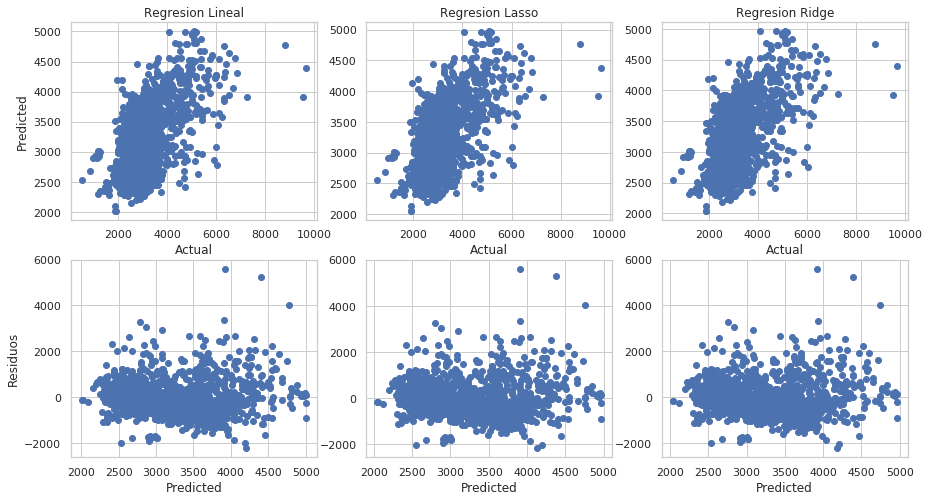

In [279]:
#Modelo 4 -- Variables sin Estandarizar en dataset con discretizacion de barrios

X4 = df2[['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado']]
y4 = df2.precio

X_train, X_test, y_train, y_test = train_test_split(X4, y4, random_state=123)

ml4 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 0.01 , 20)


y_pred_lm , y_pred_test_lm = ml4.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml4.Lasso()
y_pred_ridge , y_pred_test_ridge = ml4.Ridge()


plots()

------ Regresion Lineal ------

R2 Train: 0.3577842260687406 -- R2 Test: 0.3916962562494175
mse Train: 615377.5249241764 -- mse Test: 636415.1082377442


------ Modelo Lasso ------

Alpha Lasso: 2.0779310344827584
R2 Train: 0.35740294208730017 -- R2 Test: 0.3937313199272433
mse Train: 615742.8750172702 -- mse Test: 634285.9987523927


------ Modelo Ridge ------

Alpha Ridge: 20.0
R2 Train: 0.3574618966490961 -- R2 Test: 0.3929817413777218
mse Train: 615686.3841713682 -- mse Test: 635070.2173580274


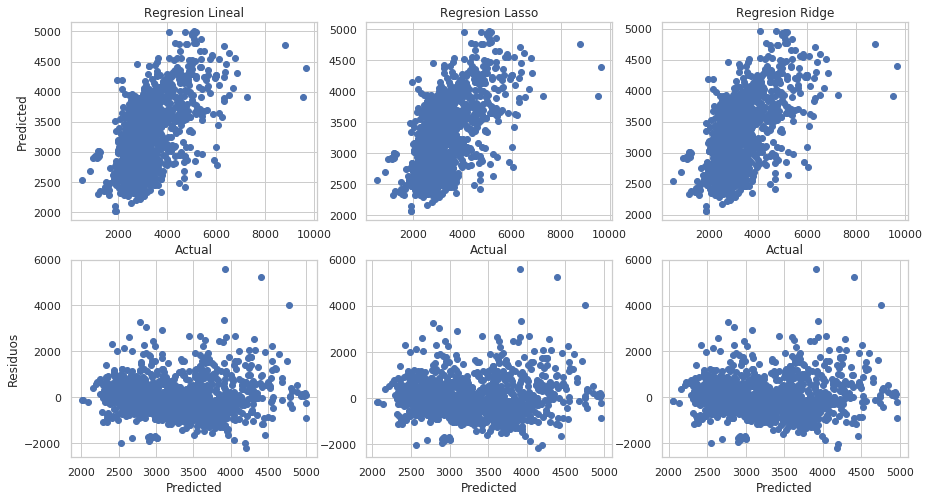

In [280]:
#Modelo 5 -- Variables Estandarizadas en dataset con discretizacion de barrios

X5 = df2[['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado']]
y5 = df2.precio

se = StandardScaler()

X5 = se.fit_transform(X5)


X_train, X_test, y_train, y_test = train_test_split(X5, y5, random_state=123)

ml5 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 0.01 , 20)


y_pred_lm , y_pred_test_lm = ml5.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml5.Lasso()
y_pred_ridge , y_pred_test_ridge = ml5.Ridge()

plots()

------ Regresion Lineal ------

R2 Train: 0.9860328998221659 -- R2 Test: -1.5779631467756136e+19
mse Train: 13383.41393452534 -- mse Test: 1.6508851000301147e+25


------ Modelo Lasso ------

Alpha Lasso: 12.24137931034483
R2 Train: 0.580398927039019 -- R2 Test: 0.5008369755869908
mse Train: 402065.91026818275 -- mse Test: 522230.70049086935


------ Modelo Ridge ------

Alpha Ridge: 20.0
R2 Train: 0.7937867660876134 -- R2 Test: 0.3843077070786005
mse Train: 197595.566229735 -- mse Test: 644145.1022885344


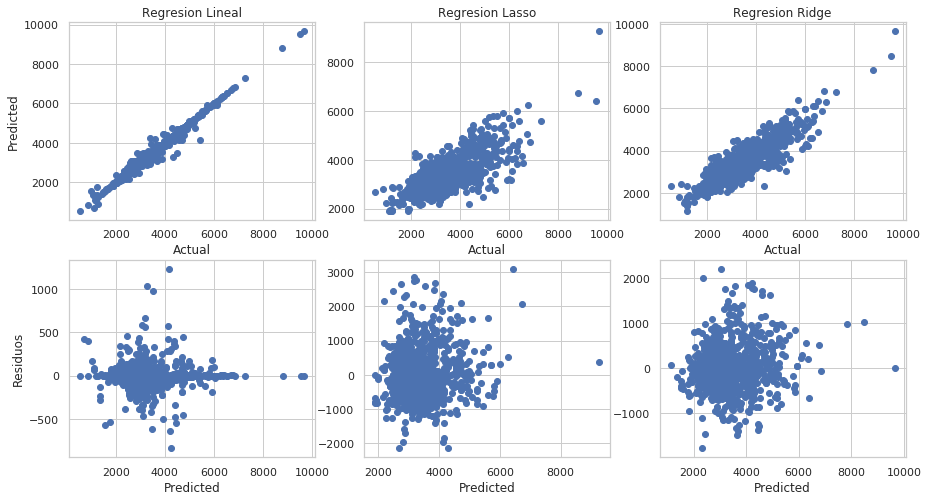

In [282]:
#Modelo 6 -- Modelo de Grado 3.

X6 = df2[['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado']]

y6 = df2.precio

# Creo un polinomio de grado 3 y transformo el data set
poly = PolynomialFeatures(degree=3)
se = StandardScaler()

X6 = poly.fit_transform(X6)
X6 = se.fit_transform(X6)


X_train, X_test, y_train, y_test = train_test_split(X6, y6, random_state=123)

ml6 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 5 , 20)


y_pred_lm , y_pred_test_lm = ml6.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml6.Lasso()
y_pred_ridge , y_pred_test_ridge = ml6.Ridge()


plots()

------ Regresion Lineal ------

R2 Train: 0.35219436478661525 -- R2 Test: 0.39387388112606525
mse Train: 0.053439409026633085 -- mse Test: 0.054383237719482995


------ Modelo Lasso ------

Alpha Lasso: 1e-06
R2 Train: 0.3521943640990658 -- R2 Test: 0.39387542269548337
mse Train: 0.053439409083351076 -- mse Test: 0.054383099405799565


------ Modelo Ridge ------

Alpha Ridge: 2.0
R2 Train: 0.35219075494121255 -- R2 Test: 0.39384009248287977
mse Train: 0.05343970681349154 -- mse Test: 0.05438626932587208


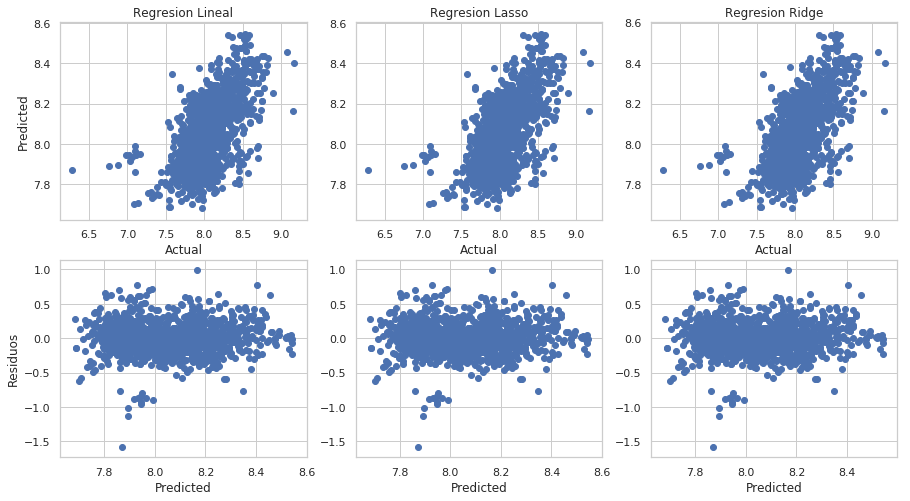

In [284]:
#Modelo 9 -- Modelo Logaritmico.

X9 = df2[['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado']]

y9 = df2.precio

se = StandardScaler()
X9 = X9.applymap(lambda x: np.log(x + 1))
X9 = se.fit_transform(X9)

y9 = np.log(y9)


X_train, X_test, y_train, y_test = train_test_split(X9, y9, random_state=123)

ml9 = ModeloDeRegresion(X_train , y_train , X_test , y_test , 0.000001 , 2)


y_pred_lm , y_pred_test_lm = ml9.RegresionLineal()
y_pred_lasso , y_pred_test_lasso , intercepto , coeffs = ml9.Lasso()
y_pred_ridge , y_pred_test_ridge = ml9.Ridge()


plots()

In [258]:
df2['error'] = y_train - y_pred_lasso
df2['error_abs'] = np.abs(y_train - y_pred_lasso)

In [259]:
df2.head()

,superficie,ambientes,pileta,parrilla,seguridad,balcon,cochera,dist_comisarias,dist_subte,dist_trenes,dist_metrobus,precio,Botanico,Chico,Falso Belgrano,Freud,Hollywood,Las Cañitas,Norte,Nuevo,Pacifico,Soho,Zoo,pozo,usado,error,error_abs
0,104.0,3,0,0,0,1,0,719.300376,991.604946,794.459912,1500.489635,3365.384615,0,0,0,0,0,0,1,0,0,0,0,0,1,NaN,NaN
1,68.0,2,1,0,0,0,0,980.716124,906.891789,260.100239,876.358223,3455.882353,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.001980,0.001980
2,69.0,2,1,0,0,0,1,894.771967,791.276622,371.547893,766.818862,3447.753623,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.088579,0.088579
3,39.0,1,0,1,1,1,0,354.987173,115.947579,1737.834489,1285.978768,3776.923077,0,0,0,0,0,0,0,0,0,0,0,0,0,0.154219,0.154219
4,47.0,2,0,0,0,1,0,773.123345,357.007275,326.555566,190.245217,2872.340426,0,0,0,0,0,0,0,0,1,0,0,0,0,0.040084,0.040084


In [153]:
pd.set_option('display.max_columns', None)
subset = df2.loc[df2['precio'] > 8000].sort_values(by='error_abs' , ascending=False).head(20)
subset

,superficie,ambientes,pileta,parrilla,seguridad,balcon,cochera,dist_comisarias,dist_subte,dist_trenes,dist_metrobus,precio,Botanico,Chico,Falso Belgrano,Freud,Hollywood,Las Cañitas,Norte,Nuevo,Pacifico,Soho,Zoo,pozo,usado,error,error_abs
481,147.0,4,1,1,0,1,1,668.421112,655.082839,745.363942,483.753583,9523.809524,0,0,0,0,0,0,0,0,0,1,0,0,0,3120.337180,3120.337180
593,128.0,3,1,1,1,0,1,767.540782,456.755380,520.346160,437.813271,8789.062500,0,0,0,0,0,0,0,1,0,0,0,0,0,2071.606325,2071.606325
482,145.0,4,1,1,0,1,1,577.996288,979.182711,886.000216,1337.504597,9655.172414,0,0,0,0,0,0,1,0,0,0,0,0,0,392.630516,392.630516
1039,35.0,1,0,0,0,0,0,230.115263,125.258464,519.288692,125.977539,8068.237714,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN


## Extrayendo las dos observaciones conflictivas

In [159]:
excluir_indices = df2.iloc[[481 , 593]]
excluir_indices

,superficie,ambientes,pileta,parrilla,seguridad,balcon,cochera,dist_comisarias,dist_subte,dist_trenes,dist_metrobus,precio,Botanico,Chico,Falso Belgrano,Freud,Hollywood,Las Cañitas,Norte,Nuevo,Pacifico,Soho,Zoo,pozo,usado,error,error_abs
481,147.0,4,1,1,0,1,1,668.421112,655.082839,745.363942,483.753583,9523.809524,0,0,0,0,0,0,0,0,0,1,0,0,0,3120.337180,3120.337180
593,128.0,3,1,1,1,0,1,767.540782,456.755380,520.346160,437.813271,8789.062500,0,0,0,0,0,0,0,1,0,0,0,0,0,2071.606325,2071.606325


In [164]:
df3 = df2[~df2.index.isin([481 , 593])]
print("Antes {}".format(df2.shape))
print("Despues {}".format(df3.shape))

Antes (1770, 27)
Despues (1768, 27)


------ Regresion Lineal ------

R2 Train: 0.9882355209890475 -- R2 Test: -2.158044820929559e+19
mse Train: 10781.095335717739 -- mse Test: 2.2064644503076904e+25




/home/juanma/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/juanma/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/juanma/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/juanma/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

------ Modelo Lasso ------

Alpha Lasso: 12.451724137931032
R2 Train: 0.5811393100639515 -- R2 Test: 0.47061646748138264
mse Train: 383848.44975973427 -- mse Test: 541261.2072521739


------ Modelo Ridge ------

Alpha Ridge: 100.0
R2 Train: 0.7208911327407121 -- R2 Test: 0.45059022157080575
mse Train: 255778.37353997226 -- mse Test: 561736.7781236697


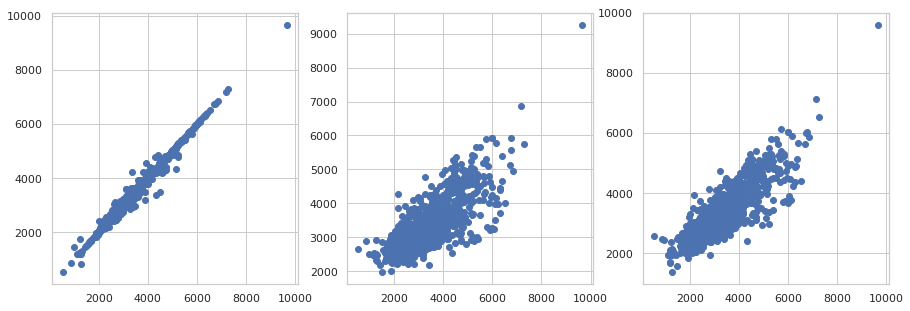

In [166]:
#Modelo 7 -- Modelo de Grado 3.

X7 = df3[['superficie', 'ambientes', 'pileta', 'parrilla', 'seguridad', 'balcon',
       'cochera', 'dist_comisarias', 'dist_subte', 'dist_trenes',
       'dist_metrobus', 'Botanico', 'Chico', 'Falso Belgrano',
       'Freud', 'Hollywood', 'Las Cañitas', 'Norte', 'Nuevo', 'Pacifico',
       'Soho', 'Zoo', 'pozo', 'usado']]

y7 = df3.precio

poly = PolynomialFeatures(degree=3)
se = StandardScaler()

X7 = poly.fit_transform(X7)
X7 = se.fit_transform(X7)


X_train, X_test, y_train, y_test = train_test_split(X7, y7, random_state=123)

ml7 = ModeloDeRegresion(X_train , y_train , X_test , y_test)


y_pred_lm , y_pred_test_lm = ml7.RegresionLineal()
y_pred_lasso , y_pred_test_lasso = ml7.Lasso()
y_pred_ridge , y_pred_test_ridge = ml7.Ridge()


fig = plt.figure(figsize=(15,5))

ax2 = fig.add_subplot(131)
ax2.scatter(y_train , y_pred_lm)
ax2 = fig.add_subplot(132)
ax2.scatter(y_train , y_pred_lasso)
ax3 = fig.add_subplot(133)
ax3.scatter(y_train , y_pred_ridge)